In [1]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from core.kernel import ARDKernel
import torch.optim as optim
import core.GP_CommonCalculation as GP
from data_sample import generate_example_data as data
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Fixing strange error if run in MacOS
JITTER = 1e-6
EPS = 1e-10
PI = 3.1415

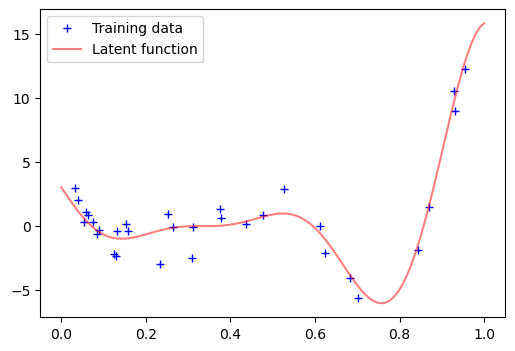

In [2]:
 # generate example data
xtr, ytr, xte, yte = data.generate(32, 100, seed=42)
data.plot(xtr, ytr, xte, yte, figsize=(6, 4))

In [3]:
normalizer = GP.DataNormalization(method="standard", mode=0, learnable=False)
normalizer.fit(xtr, 'xtr')
normalizer.fit(ytr, 'ytr')
xtr = normalizer.normalize(xtr, 'xtr')
ytr = normalizer.normalize(ytr, 'ytr')

In [4]:
kernel = ARDKernel(1)

In [5]:
#initiate_log_beta
log_beta = nn.Parameter(torch.ones(1) * -4)  # this is a large noise. we optimize to shrink it to a proper value.

In [6]:
def negative_log_likelihood(xtr, ytr, kernel, log_beta):
    Sigma = kernel(xtr, xtr) + log_beta.exp().pow(-1) * torch.eye(
        xtr.size(0)) + JITTER * torch.eye(xtr.size(0))
    return -GP.Gaussian_log_likelihood(ytr, Sigma)

In [7]:
def forward(xtr, ytr, xte, kernel, log_beta):
    n_test = xte.size(0)
    xte = normalizer.normalize(xte, 'xtr')
    Sigma = kernel(xtr, xtr) + log_beta.exp().pow(-1) * torch.eye(
        xtr.size(0)) + JITTER * torch.eye(xtr.size(0))

    K_s = kernel(xtr, xte)
    K_ss = kernel(xte, xte)

    mean, var = GP.conditional_Gaussian(ytr, Sigma, K_s, K_ss)

    var_diag = var.sum(dim=0).view(-1, 1)
    var_diag = var_diag + log_beta.exp().pow(-1)

    # Denormalize
    mean = normalizer.denormalize(mean, "ytr")
    var_diag = normalizer.denormalize_cov(var_diag, "ytr")
    return mean, var_diag

In [8]:
def train_adam(xtr, ytr, kernel, log_beta, niteration=10, lr=0.1):
    # Adam optimizer
    optimizer = optim.Adam([
        {'params': kernel.parameters()},
        {'params': [log_beta]}
    ], lr=lr)

    for i in range(niteration):
        optimizer.zero_grad()
        loss = negative_log_likelihood(xtr, ytr, kernel, log_beta)
        loss.backward()
        optimizer.step()

        # Print kernel parameters
        #for name, param in kernel.named_parameters():
        #if param.requires_grad:
        #print(f'{name}: {param.data}')

        #print('log_beta:', log_beta.data)
    print('iter', i, 'nll:{:.5f}'.format(loss.item()))

In [9]:
train_adam(xtr, ytr, kernel, log_beta, niteration=100, lr=0.1)

iter 99 nll:23.50842


In [10]:
with torch.no_grad():
    ypred, yvar = forward(xtr, ytr, xte, kernel, log_beta)

In [11]:
xtr = normalizer.denormalize(xtr, 'xtr')
ytr = normalizer.denormalize(ytr, 'ytr')

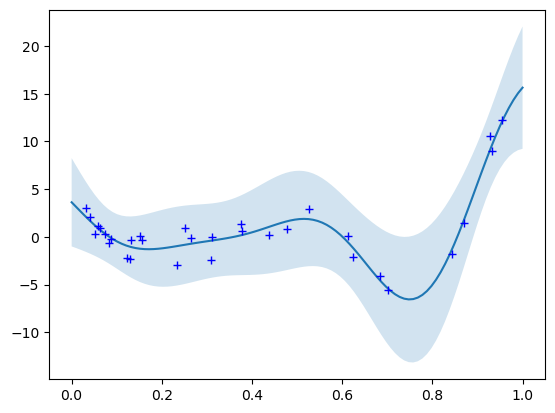

In [12]:
plt.fill_between(xte.squeeze().numpy(),
                 ypred.squeeze().detach().numpy() - 1.96 * np.sqrt(yvar.squeeze().detach().numpy()),
                 ypred.squeeze().detach().numpy() + 1.96 * np.sqrt(yvar.squeeze().detach().numpy()), alpha=0.2,
                 label='95% Confidence interval')
plt.plot(xte.squeeze().numpy(), ypred.squeeze().detach().numpy(), label='Predictive mean')
plt.plot(xtr.detach().numpy(), ytr.detach().numpy(), 'b+')
plt.show()